# Randomized Benchmarking

## Introduction 

One of the main challenges in building a quantum information processor is the non-scalability of completely
characterizing the noise affecting a quantum system via process tomography. In addition, process tomography is sensitive to noise in the pre- and post-rotation gates plus the measurements (SPAM errors). Gateset tomography can take these errors into account, but the scaling is even worse.  A complete characterization
of the noise is useful because it allows for  the determination of good error-correction schemes, and thus
the possibility of reliable transmission of quantum information.

Since complete process tomography is infeasible for large systems, there is growing interest in scalable
methods for partially characterizing the noise affecting a quantum system. A scalable (in the number $n$ of qubits comprising the system) and robust algorithm for benchmarking the full set of Clifford gates by a single parameter using randomization techniques was presented in [1]. The concept of using randomization methods for benchmarking quantum gates is commonly called **Randomized Benchmarking
(RB)**.

## The Randomized Benchmarking protocol 

A RB protocol (see [1,2]) consists of the following steps:

### Step 1: Generate RB sequences

The RB sequences consist of random Clifford elements chosen uniformly from the Clifford group on $n$-qubits, 
including a computed reversal element,
that should return the qubits to the initial state.

More precisely, for each length $m$, we choose $K_m$ RB sequences. 
Each such sequence contains $m$ random elements $C_{i_j}$ chosen uniformly from the Clifford group on $n$-qubits, and the $m+1$ element is defined as follows: $C_{i_{m+1}} = (C_{i_1}\cdot ... \cdot C_{i_m})^{-1}$. It can be found efficiently by the Gottesmann-Knill theorem.

For example, we generate below several sequences of 2-qubit Clifford circuits.

In [1]:
from qiskit_experiments.library import StandardRB

NUM_SAMPLES = 5
LENGTHS = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]

rb = StandardRB(
    physical_qubits=[0, 1],
    # Number of Cliffords in the sequence
    lengths=LENGTHS,
    # Number of circuits for each number of Cliffords
    num_samples=NUM_SAMPLES,
    seed=5,
)

As an example, we print the circuit corresponding to the first RB sequence

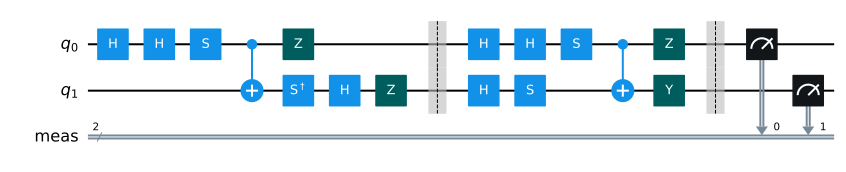

In [2]:
rb.circuits()[0].decompose().draw()

One can verify that the unitary representing each RB circuit should be the identity (with a global phase). The following cell does this using Qiskit's `Operator` class.

In [3]:
# Copy one of the circuits with no measurements
qc = rb.circuits()[1].copy()
qc.remove_final_measurements()

# Simulate unitary by turning into `Operator` object
from qiskit.quantum_info import Operator

op = Operator(qc)

# Show result
from qiskit.visualization import array_to_latex

array_to_latex(op.data, prefix="\\text{Unitary} = ")

<IPython.core.display.Latex object>

### Step 2: Execute the RB sequences (with some noise)

We can execute the RB sequences either using the Qiskit Aer simulator (with a noise model) or using the IBM Quantum provider, and obtain a list of results.

By assumption, each operation $C_{i_j}$ may have some error, represented by $\Lambda_{i_j,j}$, and each sequence can be modeled by the operation:


$$\textit{S}_{i_m} = \bigcirc_{j=1}^{m+1} (\Lambda_{i_j,j} \circ C_{i_j})$$


where ${i_m} = (i_1,...,i_m)$ and $i_{m+1}$ is uniquely determined by ${i_m}$.

The following code cell creates a noise model and adds this to a simulator.

In [4]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Create noise model
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx
# (assuming the u1 is virtual-Z gate and no error)
GATE_ERRORS = {"u2": 0.002, "u3": 0.004, "cx": 0.01}

for gate, error in GATE_ERRORS.items():
    nqubits = 2 if gate == "cx" else 1
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error, nqubits), gate)

backend = AerSimulator(noise_model=noise_model)

The following code cell transpiles the circuits and runs them.

In [5]:
from qiskit import transpile

circuits = sorted(rb.circuits(), key=lambda x: x.metadata["xval"])
transpiled_circuits = transpile(circuits, backend, optimization_level=1)

counts_list = backend.run(transpiled_circuits, shots=10_000).result().get_counts()

### Step 3: Get statistics about the survival probabilities

For each of the $K_m$ sequences the survival probability $\text{Tr}[E_\psi \textit{S}_{\textbf{i}_\textbf{m}}(\rho_\psi)]$
is measured. 
Here $\rho_\psi$ is the initial state taking into account preparation errors and $E_\psi$ is the
POVM element that takes into account measurement errors.
In the ideal (noise-free) case $\rho_\psi = E_\psi = | \psi {\rangle} {\langle} \psi |$. 

In practice one can measure the probability to go back to the exact initial state, i.e. all the qubits in the ground state $ {|} 00...0 {\rangle}$ or just the probability for one of the qubits to return back to the ground state. Measuring the qubits independently can be more convenient if a correlated measurement scheme is not possible. Both measurements will fit to the same decay parameter according to the properties of the *twirl*. 

In [6]:
# Convert counts for each circuit to survival probabilities
survival_probabilities = [counts["00"] / sum(counts.values()) for counts in counts_list]

### Step 4: Find the averaged sequence fidelity

Average over the $K_m$ random realizations of the sequence to find the averaged sequence **fidelity**,


$$F_{seq}(m,|\psi{\rangle}) = \text{Tr}[E_\psi \textit{S}_{K_m}(\rho_\psi)]$$


where 


$$\textit{S}_{K_m} = \frac{1}{K_m} \sum_{\textbf{i}_\textbf{m}} \textit{S}_{\textbf{i}_\textbf{m}}$$


is the average sequence operation.

In [7]:
# Get average survival probabilities for circuits with the same number of Cliffords
averaged_survival_probabilities = [
    sum(survival_probabilities[i * NUM_SAMPLES : (i + 1) * NUM_SAMPLES]) / NUM_SAMPLES
    for i in range(len(LENGTHS))
]

### Step 5: Fit the results

Repeat Steps 1 through 4 for different values of $m$ and fit the results for the averaged sequence fidelity to the model:


$$ \textit{F}_{seq}^{(0)} \big(m,{|}\psi {\rangle} \big) = A_0 \alpha^m +B_0$$


where $A_0$ and $B_0$ absorb state preparation and measurement errors as well as an edge effect from the
error on the final gate.

$\alpha$ determines the average error-rate $r$, which is also called **Error per Clifford (EPC)** 
according to the relation 

$$ r = 1-\alpha-\frac{1-\alpha}{2^n} = \frac{2^n-1}{2^n}(1-\alpha)$$


(where $n$ is the number of qubits).

The following cell fits the results to an exponential curve, which tells us $\alpha$. We then use this to calculate the EPC.

In [8]:
from scipy.optimize import curve_fit


def func(m, alpha, A0, B0):
    return A0 * (alpha**m) + B0


alpha, A0, B0 = curve_fit(func, LENGTHS, averaged_survival_probabilities)[0]
EPC = 3 * (1 - alpha) / 4  # for 2 qubits

print(f"alpha: ~{alpha:.4f}\n" f"  EPC: ~{EPC:.4f}")

alpha: ~0.9759
  EPC: ~0.0180


### Extra Step: Plot the results

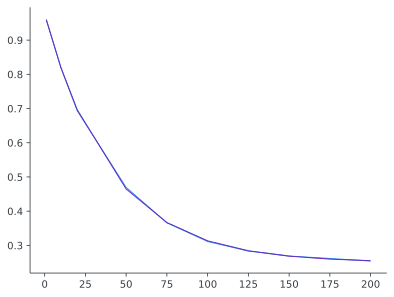

In [9]:
from matplotlib import pyplot as plt

plt.plot(LENGTHS, averaged_survival_probabilities)  # experiment data
plt.plot(LENGTHS, [func(i, alpha, A0, B0) for i in LENGTHS]);  # fitted curve

## Using the `qiskit-experiments` library

We've already used the `StandardRB` class to generate RB circuits, but we can also use this class to carry out the full RB experiment. You may notice a small difference to the result we calculated before. This is because the `StandardRB` class uses a slightly different transpilation process.

alpha: 0.9738+/-0.0005
EPC: 0.0197+/-0.0004
EPG_cx: 0.01182+/-0.00022


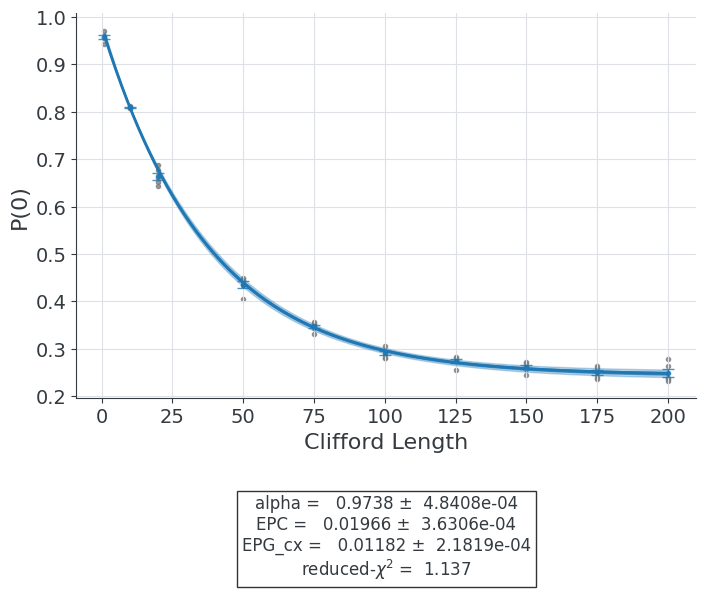

In [10]:
experiment_data = rb.run(backend).block_for_results()
for result in experiment_data.analysis_results()[1:]:
    print(f"{result.name}: {result.value}")
experiment_data.figure(0)

## The Intuition Behind RB 

The depolarizing quantum channel has a parameter $\alpha$, and works like this: with probability $\alpha$, the state remains the same as before; with probability $1-\alpha$, the state becomes the totally mixed state, namely:



$$\rho_f = \alpha \rho_i + \frac{1-\alpha}{2^n} * \mathbf{I}$$



Suppose that we have a sequence of $m$ gates, not necessarily Clifford gates, 
where the error channel of the gates is a depolarizing channel with parameter $\alpha$ 
(same $\alpha$ for all the gates). 
Then with probability $\alpha^m$ the state is correct at the end of the sequence, 
and with probability $1-\alpha^m$ it becomes the totally mixed state, therefore:



$$\rho_f^m = \alpha^m \rho_i + \frac{1-\alpha^m}{2^n} * \mathbf{I}$$



Now suppose that in addition we start with the ground state; 
that the entire sequence amounts to the identity; 
and that we measure the state at the end of the sequence with the standard basis. 
We derive that the probability of success at the end of the sequence is:



$$\alpha^m + \frac{1-\alpha^m}{2^n} = \frac{2^n-1}{2^n}\alpha^m + \frac{1}{2^n} =  A_0\alpha^m + B_0$$



It follows that the probability of success, aka fidelity, decays exponentially with the sequence length, with exponent $\alpha$.

The last statement is not necessarily true when the channel is other than the depolarizing channel. However, it turns out that if the gates are uniformly-randomized Clifford gates, then the noise of each gate behaves on average as if it was the depolarizing channel, with some parameter that can be computed from the channel, and we obtain the exponential decay of the fidelity.

Formally, taking an average over a finite group $G$ (like the Clifford group) of a quantum channel $\bar \Lambda$ is also called a *twirl*:


$$ W_G(\bar \Lambda) \frac{1}{|G|} \sum_{u \in G} U^{\dagger} \circ  \bar \Lambda \circ U$$


Twirling over the entire unitary group yields exactly the same result as the Clifford group. The Clifford group is a *2-design* of the unitary group.

## Simultaneous Randomized Benchmarking 


RB is designed to address fidelities in multiqubit systems in two ways. For one, RB over the full $n$-qubit space
can be performed by constructing sequences from the $n$-qubit Clifford group. Additionally, the $n$-qubit space
can be subdivided into sets of qubits $ \{n_i\} $ and $n_i$-qubit RB performed in each subset simultaneously [4]. 
Both methods give metrics of fidelity in the $n$-qubit space. 

For example, it is common to perform 2Q RB on the subset of two-qubits defining a CNOT gate while the other qubits are inactive. As explained in [4], this RB data will not necessarily decay exponentially because the other qubit subspaces are not twirled. Subsets are more rigorously characterized by simultaneous RB, which also measures some level of crosstalk error since all qubits are active.

An example of simultaneous RB (1Q RB and 2Q RB) can be found in: 
https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/noise/4_randomized_benchmarking.ipynb

## Predicted Gate Fidelity 

If we know the errors on the underlying gates (the gateset) we can predict the EPC without running RB experiment. This calculation verifies that your RB experiment followed by fitting yields correct EPC value. First we need to count the number of these gates per Clifford.

In [11]:
total_basis_gates = {}
for circuit in transpiled_circuits:
    for gate, count in circuit.count_ops().items():
        if gate not in total_basis_gates:
            total_basis_gates[gate] = 0
        total_basis_gates[gate] += count

total_cliffords = sum(LENGTHS) * NUM_SAMPLES
gates_per_clifford = {
    gate: count / total_cliffords for gate, count in total_basis_gates.items()
}

gates_per_clifford

{'u3': 3.077924944812362,
 'cx': 1.4640176600441501,
 'barrier': 1.011037527593819,
 'measure': 0.02207505518763797,
 'u2': 0.3205298013245033}

Next, we calculate the probability that an error occurs. The depolarizing probability is the probability that our state is replaced with a random state, but this random state might happen to be the same as the one we had originally.

In [12]:
# Convert from depolarizing error to real error-rate
# (depolarizing error replaces qubit with random state,
# so there is chance this random state does not change
# measurement results)
GATE_ERRORS = {
    gate: err * 3 / 4 if gate == "cx" else err / 2 for gate, err in GATE_ERRORS.items()
}

Finally, the following cell estimates the error per Clifford gate. 

In [13]:
total_fidelity = 1
for gate, error in GATE_ERRORS.items():
    fidelity = 1 - error
    total_fidelity *= fidelity ** gates_per_clifford.get(gate, 0)
1 - total_fidelity  # estimated error per clifford

0.017351910256190983

We could also calculate the errors on the underlying gates from the experimentally obtained EPC.

In [14]:
norm = 0
for gate in GATE_ERRORS.keys():
    norm += gates_per_clifford[gate]

print(f"Calculated average error of {EPC/norm:.4f} per gate")

Calculated average error of 0.0037 per gate


Since we know the errors on the every single-qubit gates in the RB sequence, we can predict 2Q gate error from the EPC of two qubit RB experiment.

In [15]:
single_qubit_fidelity = 1
for gate in ["u2", "u3"]:
    fidelity = 1 - GATE_ERRORS[gate]
    single_qubit_fidelity *= fidelity ** gates_per_clifford.get(gate, 0)

cx_fidelity = ((1 - EPC) / single_qubit_fidelity) ** (1 / gates_per_clifford["cx"])
(1 - cx_fidelity) * 4 / 3  # Estimated CX depolarizing error

0.01063938547710963

## References 

1. Easwar Magesan, J. M. Gambetta, and Joseph Emerson, *Robust randomized benchmarking of quantum processes*,
https://arxiv.org/pdf/1009.3639

2. Easwar Magesan, Jay M. Gambetta, and Joseph Emerson, *Characterizing Quantum Gates via Randomized Benchmarking*,
https://arxiv.org/pdf/1109.6887

3. A. D. Córcoles, Jay M. Gambetta, Jerry M. Chow, John A. Smolin, Matthew Ware, J. D. Strand, B. L. T. Plourde, and M. Steffen, *Process verification of two-qubit quantum gates by randomized benchmarking*, https://arxiv.org/pdf/1210.7011

4. Jay M. Gambetta, A. D. Córcoles, S. T. Merkel, B. R. Johnson, John A. Smolin, Jerry M. Chow,
Colm A. Ryan, Chad Rigetti, S. Poletto, Thomas A. Ohki, Mark B. Ketchen, and M. Steffen,
*Characterization of addressability by simultaneous randomized benchmarking*, https://arxiv.org/pdf/1204.6308

5. David C. McKay, Sarah Sheldon, John A. Smolin, Jerry M. Chow, and Jay M. Gambetta, *Three Qubit Randomized Benchmarking*, https://arxiv.org/pdf/1712.06550

In [16]:
import qiskit.tools.jupyter

%qiskit_version_table